# Startup

In [3]:
import numpy as np
import scipy.fft

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png','pdf')

%load_ext autoreload
%autoreload 1
%aimport w7x_bes_tools.fida
%aimport w7x_bes_tools.beams
%aimport w7x_bes_tools.sightline
%aimport w7x_bes_tools.sightline_grid
%aimport w7x_bes_tools.signals
%aimport w7x_bes_tools.detectors

rng = np.random.default_rng()

save = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# W30 field of view

## Field alignment and Doppler shift

SL/beam off-normal angle = 6.18 deg
Excited state lifetime travel (vacuum) = 3.35 cm
Saving plots/S7_W30_w7x_ref_29_vplane.pdf


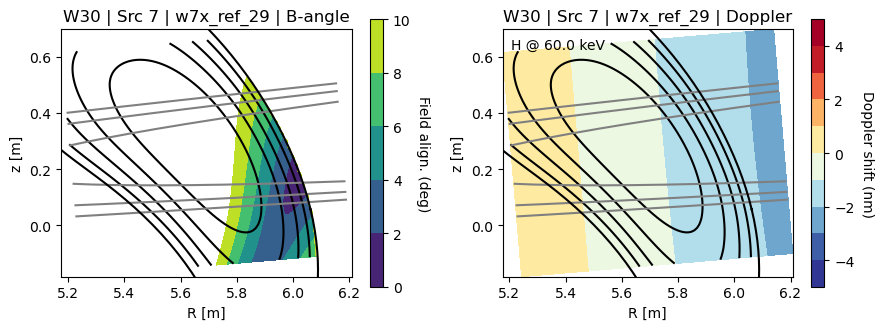

In [4]:
from w7x_bes_tools.beams import HeatingBeam
source = HeatingBeam(source=7, eq_tag='w7x_ref_29')
source.plot_beam_plane(port='W30', save=save)

## Beam density

FIDASIM results: data/FIDASIM/W30_P7
SL/beam off-normal angle = 6.18 deg
Excited state lifetime travel (vacuum) = 3.35 cm
Saving plots/fida_beam.pdf
SL/beam off-normal angle = 6.18 deg
Excited state lifetime travel (vacuum) = 3.35 cm
Saving plots/fida_beam_zoom.pdf


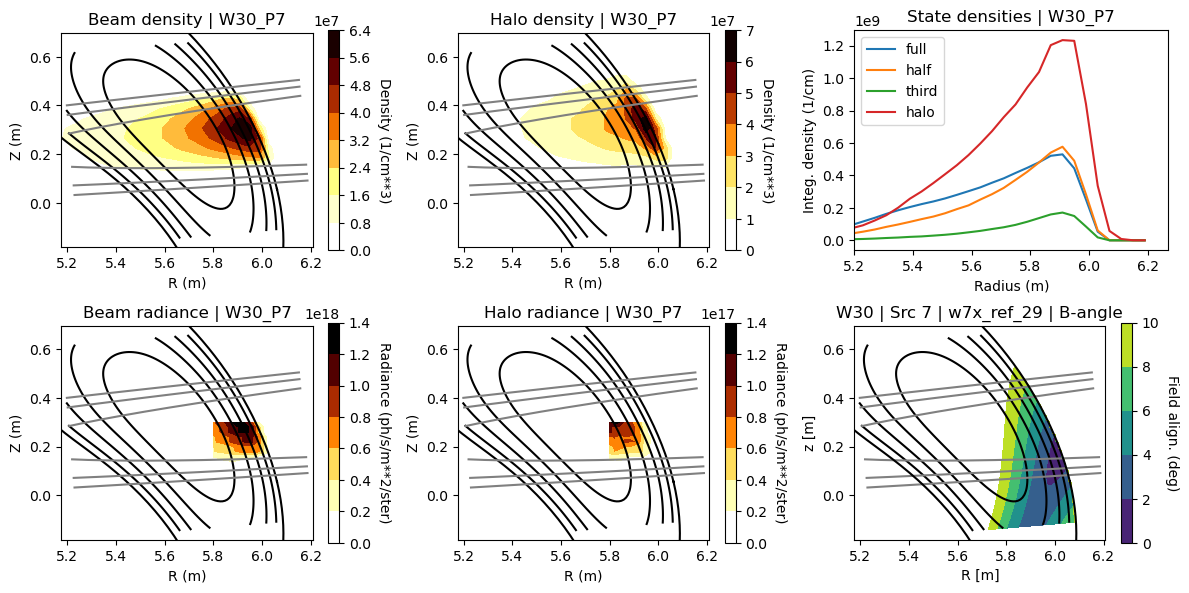

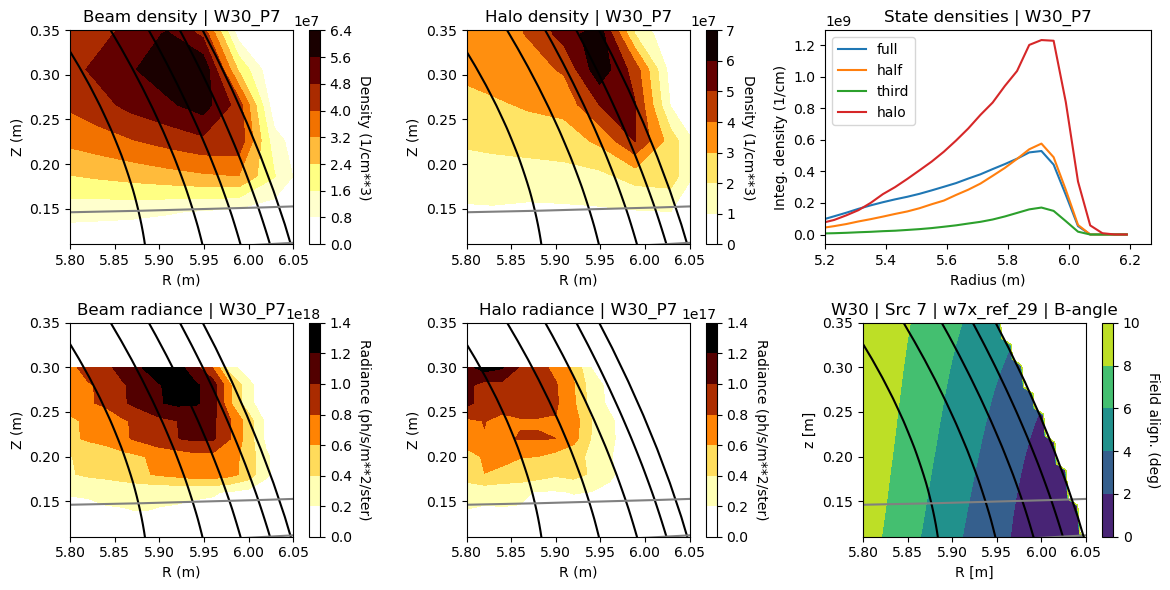

In [5]:
from w7x_bes_tools.fida import Fida
emission_spectra = Fida(simdir='W30_P7')
passband = [653,655.3]
for zoom in [False, True]:
    emission_spectra.plot_beam_plane(passband=passband, zoom=zoom, save=save)

# Sightline locations

Loaded data/grid_88_c2c14_P7_W30_R595_Z23_w7x_ref_29.pickle
Using saved sightline grid data
Sightline grid:  R (m), Z(m), phi (deg), X (m), Y (m)
  Central ray
    5.950, 0.230, 87.54, 0.255, 5.945
  Grid corners
    5.888, 0.256, 87.58, 0.249, 5.883
    5.976, 0.294, 87.52, 0.258, 5.971
    5.924, 0.166, 87.56, 0.253, 5.918
    6.012, 0.204, 87.50, 0.262, 6.007
SL/beam off-normal angle = 6.18 deg
Excited state lifetime travel (vacuum) = 3.35 cm
Max rad/binorm excursion (cm): 2.55 1.70
Min/max psinorm: 0.36 0.96
Min/max R (m): 5.89 6.01
Saving plots/grid_88_c2c14_P7_W30_R595_Z23_w7x_ref_29.pdf
Loaded data/grid_88_c2c14_P7_W30_R591_Z23_w7x_ref_29.pickle
Using saved sightline grid data
Sightline grid:  R (m), Z(m), phi (deg), X (m), Y (m)
  Central ray
    5.910, 0.230, 87.56, 0.251, 5.905
  Grid corners
    5.848, 0.256, 87.61, 0.244, 5.843
    5.936, 0.294, 87.55, 0.254, 5.931
    5.884, 0.166, 87.58, 0.248, 5.878
    5.972, 0.204, 87.53, 0.258, 5.967
SL/beam off-normal angle = 6.18 de

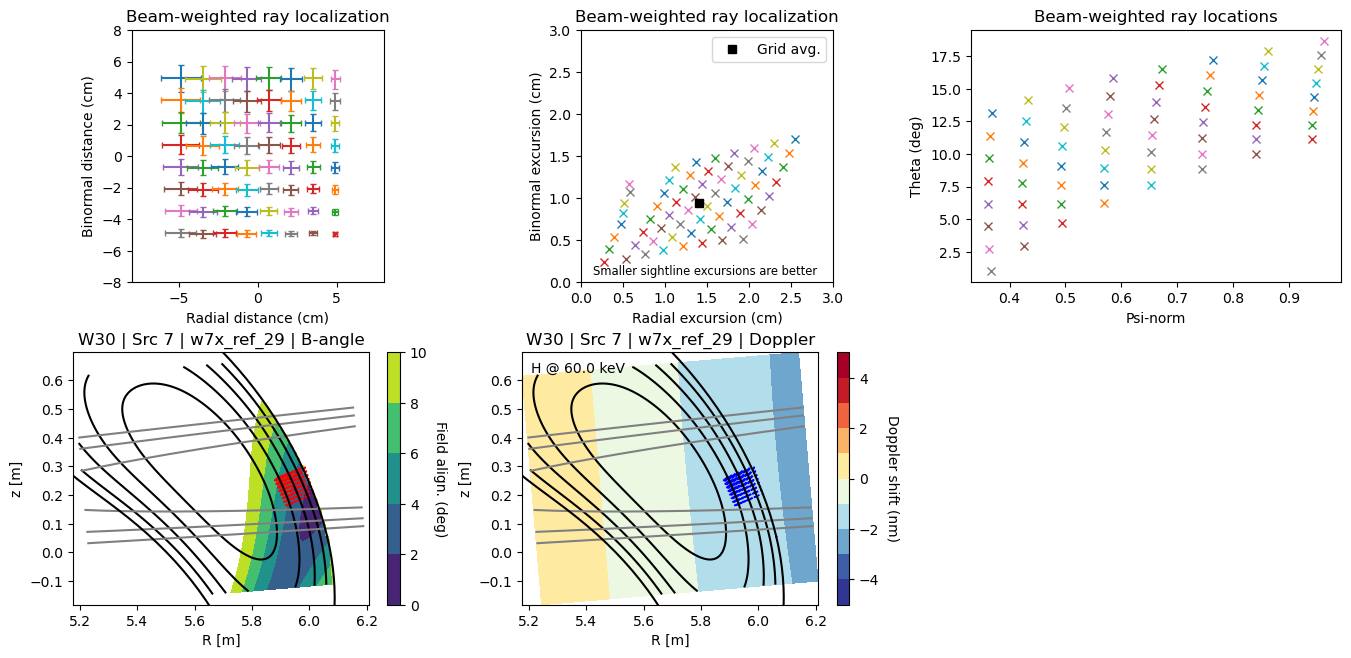

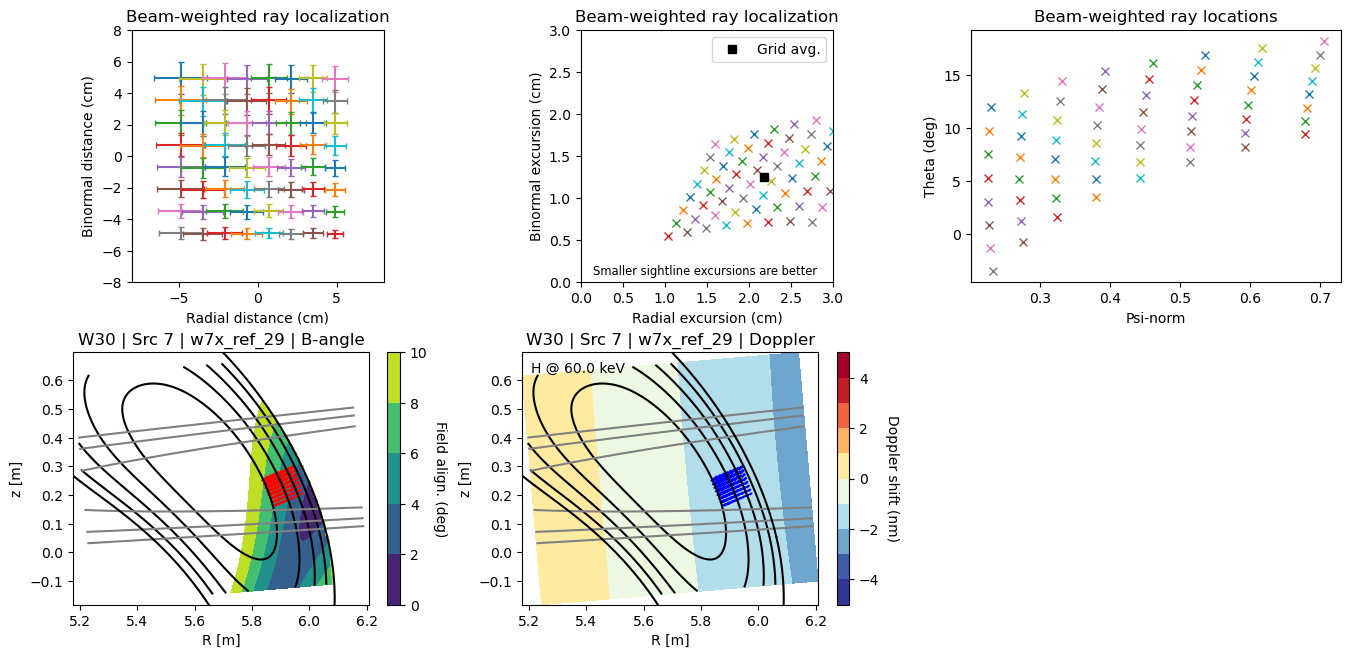

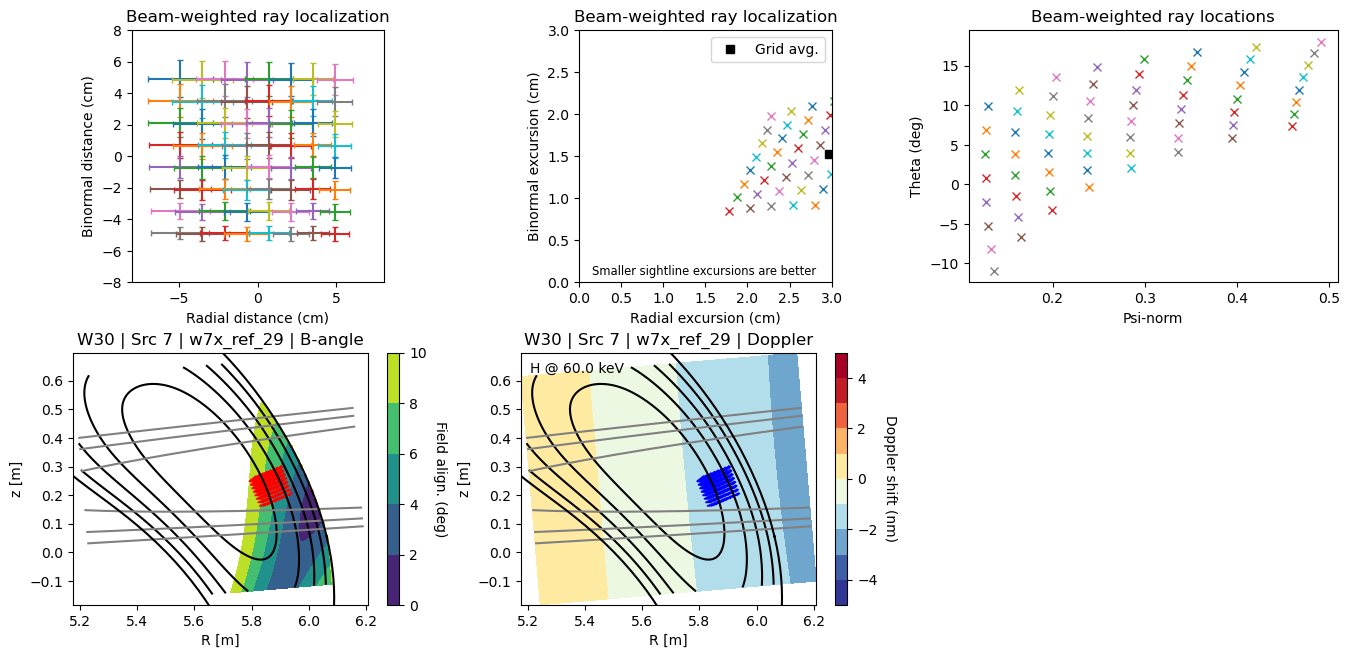

In [6]:
from w7x_bes_tools.sightline_grid import Grid

r_centers = np.array([5.95, 5.91, 5.87])  # sightline grid center, major radius (m)
z_center = 0.23  # sightline grid center, height (m)

for r_center in r_centers:
    grid = Grid(beam=source,
                port='W30',
                r_obs=r_center, 
                z_obs=z_center,
                c2c_normal=1.4,
                eq_tag='w7x_ref_29')
    grid.plot(save=save)

# Emission spectral radiance

FIDASIM results: data/FIDASIM/W30_P7
Saving plots/W30_P7_R580_Z22.pdf


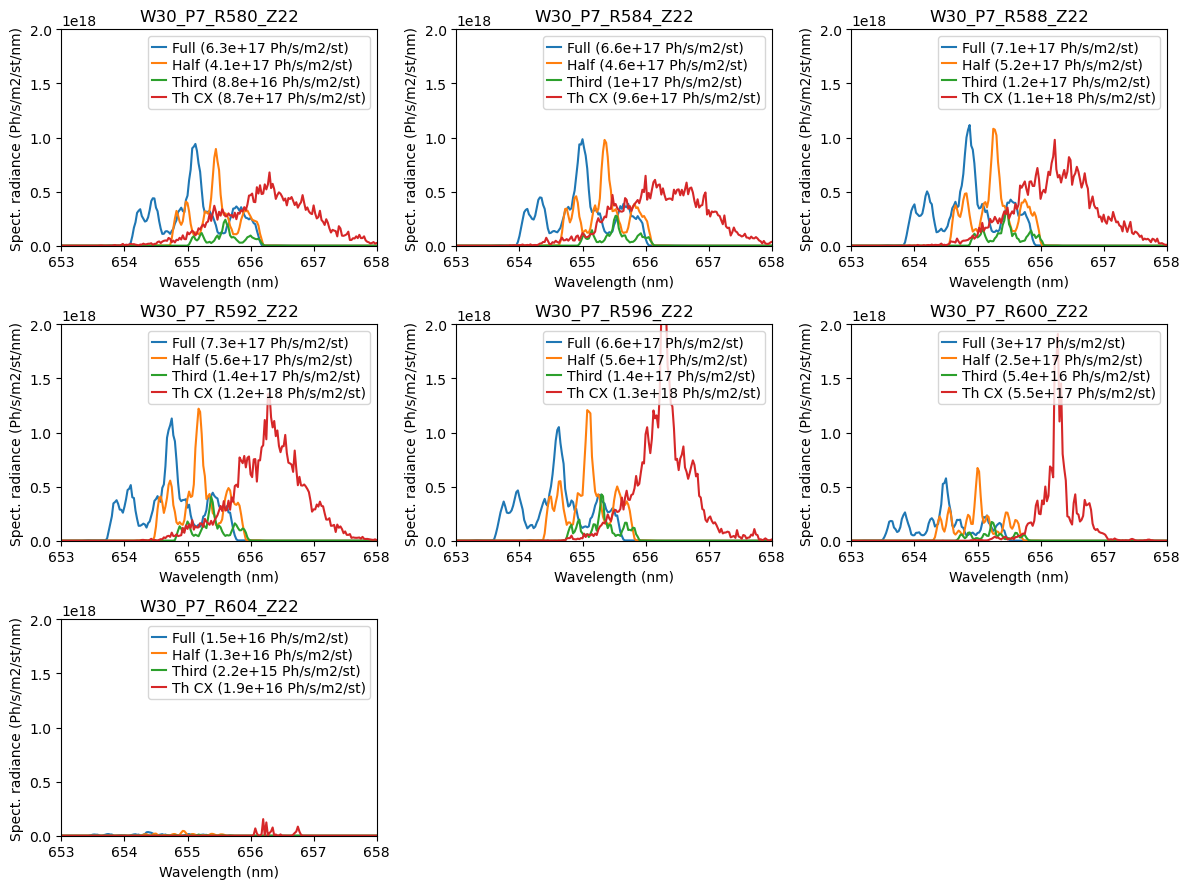

In [7]:
from w7x_bes_tools.fida import Fida
f = Fida(simdir='W30_P7')
ilos = f.los_filter(tag='Z22')
f.plot_spectra(ilos=ilos[::2], save=save)

# Emission radiance

Saving plots/fida_array_W30_P7_R580_Z22.pdf


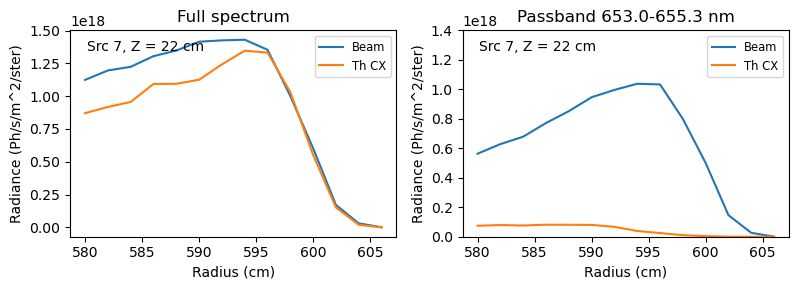

In [8]:
f.plot_radial_array(z=22, passband=[653,655.3], save=save)

# Optical throughput and emission intensity

Emitter specifications
  Port-beam distance: 230.0 cm
  Aperture diameter: 7.0 cm
  Numerical aperture: 0.0152
Emitter specifications
  Port-beam distance: 230.0 cm
  Aperture diameter: 5.0 cm
  Numerical aperture: 0.0109
Saving plots/throughput_and_intensity.pdf


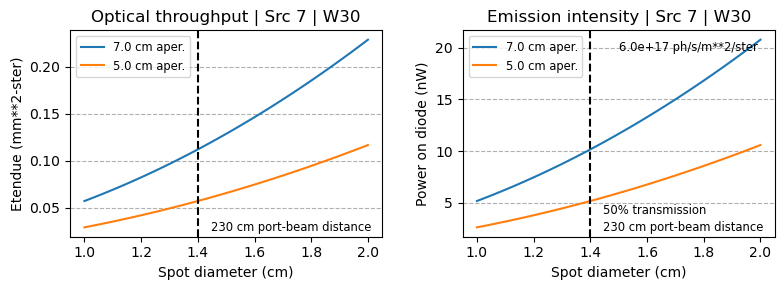

In [9]:
from w7x_bes_tools import signals
import scipy.constants as pc

apertures = [7, 5]  # aperture diameters in cm
emitters = [signals.Emitter(aperture=aperture) for aperture in apertures]

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(4*2,3))

plt.sca(axes.flat[0])
for emitter in emitters:
    # emitter.plot_etendue()
    plt.plot(emitter.spot_diameter, emitter.calc_etendue(), label=f"{emitter.aperture:.1f} cm aper.")
plt.ylabel('Etendue (mm**2-ster)')
plt.title('Optical throughput | Src 7 | W30')


radiance = 0.6e18  # ph/s/m**2/ster ; assume a radiance value at the lower end
photon_wavelength = 656e-9  # wavelength (m)
photon_energy = pc.h * pc.c / photon_wavelength  # energy per photon (J)
transmission_factor = 0.5  # assume 50% transmission loss

plt.sca(axes.flat[1])
for emitter in emitters:
    etendue = emitter.calc_etendue()  # mm**2-ster ; optical throughput for different apertures
    p_incident = photon_energy * radiance * (etendue/1e6) * transmission_factor * 1e9  # incident power (nW)
    plt.plot(emitter.spot_diameter, p_incident, label=f"{emitter.aperture:.1f} cm aper.")
plt.ylabel('Power on diode (nW)')
plt.title('Emission intensity | Src 7 | W30')
plt.annotate(f"{radiance:.1e} ph/s/m**2/ster", (0.5,0.9), xycoords='axes fraction', fontsize='small')
plt.annotate(f'{transmission_factor*1e2:.0f}% transmission', (0.45,0.11), xycoords='axes fraction', fontsize='small')

for axis in axes.flat:
    plt.sca(axis)
    plt.annotate(f'{emitters[0].distance:.0f} cm port-beam distance', (0.45,0.03), xycoords='axes fraction', fontsize='small')
    plt.xlabel('Spot diameter (cm)')
    plt.legend(fontsize='small')
    plt.axvline(1.4, ls='--', c='k')
    plt.grid(axis='y', ls='--')

plt.tight_layout()

if save:
    fname = 'plots/throughput_and_intensity.pdf'
    print(f'Saving {fname}')
    plt.savefig(fname, transparent=True)

# Instantaneous signal-to-noise

PIN
  QE = 92.6 %
  Resp. = 0.49 A/W
  Dark current (total or vol.) = 0.3 nA
  Junction cap = 15.0 pF
  Shunt res. = 250 MOhms
  Ref. bias voltage = 9 V
  Ref. temp. = 20 C
APD
  QE = 85.0 %
  Resp. = 0.45 A/W
  Dark current (total or vol.) = 1.0 nA
  Junction cap = 9.0 pF
  Shunt res. = 250 MOhms
  Ref. bias voltage = 330 V
  Ref. temp. = 20 C
  Gain = 50
  Noise index = 0.20
  Noise factor = 2.2


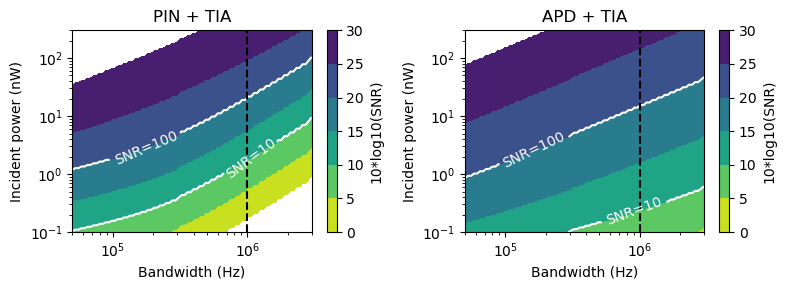

In [10]:
from w7x_bes_tools import detectors

diodes = {
    'Hama_S13620_PIN' : detectors.PinDiode(
        # name='Hama. S13620 8x8 PIN',
        name='PIN',
        responsivity=0.49,  # A/W @ 650 nm
        darkcurrent_ref=0.3e-9,  # typ 10 pA, max 300 pA @ Vr=10mV, T=20C
        junction_cap_ref=15e-12,  # typ 15 pF @ Vr=8.6V
        vb_ref=8.6,
    ),
    'Hama_S8550_APD' : detectors.ApdDiode(
        # name='Hama. S8550 4x8 APD',
        name='APD',
        qe=0.85,  # QE @ 650 nm
        gain=50,  # gain @ Vr=330 V
        darkcurrent_ref=1e-9,  # typ 1 nA, max 10 nA @ Vr=330V, M=50
        junction_cap_ref=9e-12,  # typ 9 pF @ Vr=330V, M=50
        noise_index=0.2,
        vb_ref=330,  # reference bias for gain and junction cap.
    ),
}

tia = detectors.TIA()

ncols, nrows = 2,1
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))

np_inc, nbw = 80, 80

p_inc_array = np.geomspace(1e-1,3e2,np_inc) * 1e-9  # W
f_max=3e6  # Hz
f_space = np.geomspace(1e3,f_max,80)  # Hz
f_intervals = np.diff(f_space, prepend=0)  # Hz
bw_ref_array = np.geomspace(50e3,f_max,nbw)  # Hz
temp = -20

for diode, axis in zip(diodes.values(), axes.flat):
    plt.sca(axis)
    plt.title(f'{diode.name} + TIA')
    SNR = np.zeros((np_inc, nbw))
    for ip, p_inc in enumerate(p_inc_array):
        I_photo = diode.photocurrent(p_inc=p_inc)
        diode_CNPD = (diode.photocurrent_shot_noise_CNPD(p_inc) + \
            diode.dark_current_shot_noise_CNPD(t=temp) + \
            diode.shunt_noise_CNPD(t=temp))  # nA^2/Hz
        feedback_noise_CNPD = tia.feedback_noise_CNPD(t=temp)  # nA^2/Hz
        gate_noise_CNPD = tia.gate_noise_CNPD()
        diode_junction_cap = diode.junction_cap()
        enc_noise_CNPD = tia.enc_noise_CNPD(f=f_space, diode_junction_cap=diode_junction_cap)
        TIA_noise_NCPD = enc_noise_CNPD + gate_noise_CNPD + feedback_noise_CNPD
        total_noise = TIA_noise_NCPD + diode_CNPD
        noise_times_bw = total_noise * f_intervals
        for ibw, bw_ref in enumerate(bw_ref_array):
            int_noise = np.sqrt(np.sum(noise_times_bw[f_space<=bw_ref]))  # I_n,rms
            SNR[ip, ibw] = I_photo / int_noise
    plt.contourf(
        bw_ref_array, 
        p_inc_array*1e9, 
        10*np.log10(SNR),
        levels=np.linspace(0,30,7),
        cmap='viridis_r'
        )
    plt.xscale('log')
    plt.xlabel('Bandwidth (Hz)')
    plt.yscale('log')
    plt.ylabel('Incident power (nW)')
    plt.clim(0,30)
    cb = plt.colorbar()
    cb.set_label('10*log10(SNR)')
    clines = plt.contour(
        bw_ref_array, 
        p_inc_array*1e9, 
        10*np.log10(SNR),
        levels=[10,20], colors='w')
    plt.clabel(clines, colors='w', fmt={10:'SNR=10', 20:'SNR=100'})
    plt.axvline(1e6, ls='--', c='k')

plt.tight_layout()

if save:
    plt.savefig(f'plots/detector_noise_contours.pdf')

# Frequency-resolved signal and noise

Samples: 1048576
Signal window: 1048.6 ms
Saving plots/frequency_spectra_noise_signals.pdf


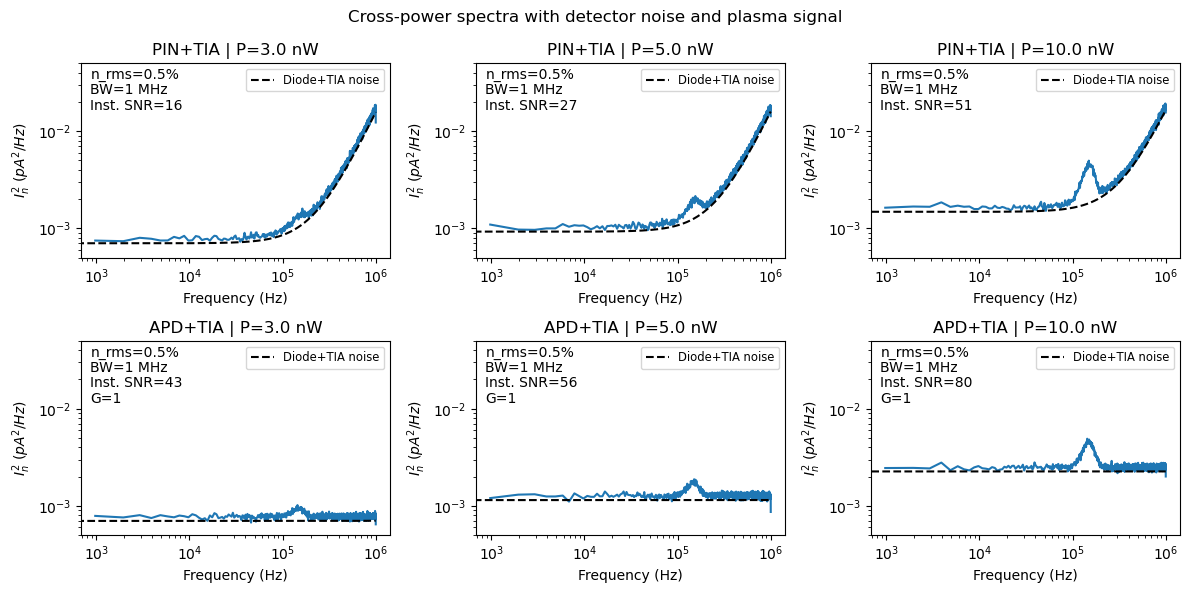

In [12]:
n_rms = 5e-3  # density RMS fluctuation

powers = np.array([3, 5, 10]) * 1e-9  # incident powers in W

f0 = 150e3  # mode center frequency, Hz
f_fwhm = 50e3  # mode FWHM, Hz
f_sd = f_fwhm / ( 2 * np.sqrt(2*np.log(2)) )  # mode frequency std. dev., Hz

f_sample = 2.e6
bw = f_sample/2

nfft = 2048
nbins = 512
nsamples = nfft * nbins
print(f"Samples: {nsamples}")
print(f"Signal window: {nsamples/1e3:.1f} ms")

freqs = scipy.fft.rfftfreq(nfft, 1/f_sample)
nfreqs = nfft//2 + 1
assert(freqs.size == nfreqs)
fres = freqs[1]
assert(fres == f_sample / nfft)

freqs_full = scipy.fft.rfftfreq(nsamples, 1/f_sample)

temp = -20  # photodiode temperature, C

ncols, nrows = powers.size, len(diodes)
_, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
plt.suptitle("Cross-power spectra with detector noise and plasma signal")

for icol, diode in enumerate(diodes.values()):
    for irow, p_inc in enumerate(powers):
        # diode CNPD (current noise power density)
        diode_CNPD = (diode.photocurrent_shot_noise_CNPD(p_inc) + \
            diode.dark_current_shot_noise_CNPD(t=temp) + \
            diode.shunt_noise_CNPD(t=temp))  # nA^2/Hz
        # TIA CNPD
        feedback_CNPD = tia.feedback_noise_CNPD(t=temp)  # nA^2/Hz
        gate_CNPD = tia.gate_noise_CNPD()
        enc_CNPD = tia.enc_noise_CNPD(f=freqs, diode_junction_cap=diode.junction_cap())
        # total CNPD (gain=1)
        total_CNPD = (enc_CNPD + gate_CNPD + feedback_CNPD + diode_CNPD) / diode.gain**2
        # RMS noise and SNR (frequency integrated)
        i_rms = np.sqrt(np.mean(total_CNPD) * bw)  # I_n,rms
        I_photo = diode.photocurrent(p_inc=p_inc) / diode.gain
        SNR = I_photo / i_rms
        # noise fourier components
        enc_noise_CNPD_full = tia.enc_noise_CNPD(f=freqs_full, diode_junction_cap=diode.junction_cap())
        total_noise_CNPD_full = (enc_noise_CNPD_full + gate_CNPD + feedback_CNPD + diode_CNPD) / diode.gain**2
        amplitudes = np.sqrt( total_noise_CNPD_full.reshape(-1,1) * bw * nsamples) * rng.standard_normal([freqs_full.size,2])
        amplitudes[0,:] = I_photo * nsamples
        phases = 2*np.pi * rng.random([freqs_full.size,2]) 
        phases[0,:] = 0
        fourier_comp = amplitudes * np.exp(1.j * phases)
        # plasma perturbation fourier components
        p_rms = p_inc * (0.5 * n_rms)  # incident power RMS fluctuation ; (dI/I)/(dn/n) = 0.5 corresponds to high n ~ 1e20/cm**3
        i_rms = diode.photocurrent(p_inc=p_rms) / diode.gain
        i2_mean_mode = i_rms**2 / bw
        i2_f_mode_rel = np.exp(-0.5*(freqs_full-f0)**2 / f_sd**2)
        i2_f_mode = i2_mean_mode * i2_f_mode_rel / np.mean(i2_f_mode_rel)
        amplitudes = np.sqrt( i2_f_mode * bw * nsamples) * rng.standard_normal(freqs_full.size)
        amplitudes[0] = 0
        phases = 2*np.pi * rng.random(freqs_full.size) 
        phases[0] = 0
        # total fourier components and signal
        fourier_comp = fourier_comp + amplitudes.reshape(-1,1) * np.exp(1.j * phases.reshape(-1,1))
        signal = np.real( scipy.fft.irfft(fourier_comp, axis=0) )
        # binned power spectrum
        psd = np.empty([nfreqs, nbins])
        for i in np.arange(nbins):
            rfft = scipy.fft.rfft(signal[nfft*i:nfft*(i+1), :], axis=0)
            psd[:,i] = np.abs(rfft[:,0] * np.conjugate(rfft[:,1])) / bw / nfft
        psd_mean = np.mean(psd, axis=1)

        plt.sca(axes[icol, irow])
        plt.title(f'{diode.name}+TIA | P={p_inc*1e9:.1f} nW')
        plt.loglog(freqs[1:], psd_mean[1:]*1e24)
        plt.loglog(freqs, total_CNPD*1e24/np.sqrt(2), label='Diode+TIA noise', c='k', ls='--')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('$I_n^2$ ($pA^2/Hz$)')
        plt.ylim(5e-4,5e-2)
        plt.annotate(f'n_rms={n_rms*1e2:.1f}%',
            xycoords='axes fraction',
            xy=[0.03,0.92])
        plt.annotate(f'BW={bw/1e6:.0f} MHz',
            xycoords='axes fraction',
            xy=[0.03,0.84])
        plt.annotate(f'Inst. SNR={SNR:.0f}',
            xycoords='axes fraction',
            xy=[0.03,0.76])
        if isinstance(diode, detectors.ApdDiode):
            plt.annotate(f'G=1',
                xycoords='axes fraction',
                xy=[0.03,0.68])
        plt.legend(loc='upper right', fontsize='small')
plt.tight_layout()

if save:
    fname = 'plots/frequency_spectra_noise_signals.pdf'
    print(f'Saving {fname}')
    plt.savefig(fname, transparent=True)